['faible' 'moyenne' 'eleve']


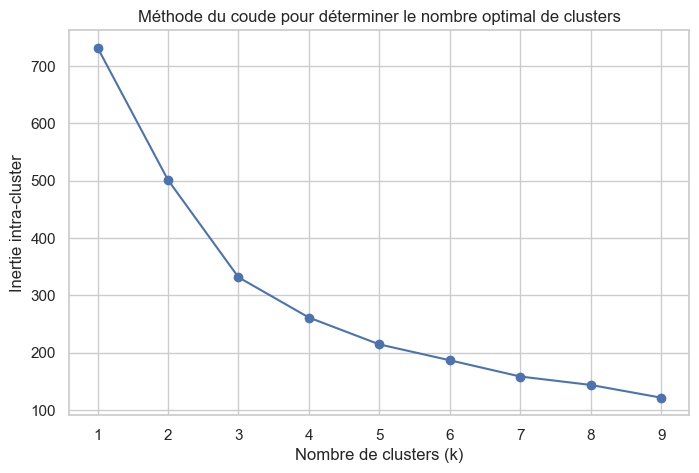

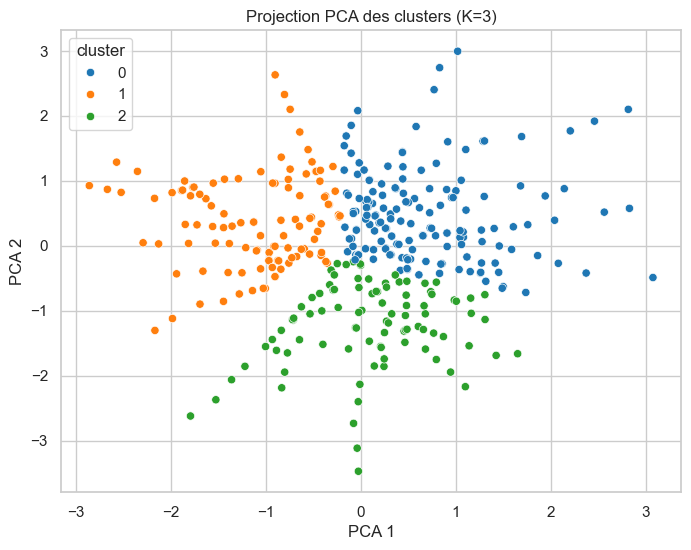

Table de contingence entre clusters et pollution réelle :
Empty DataFrame
Columns: []
Index: []
Statistiques moyennes des coordonnées par cluster :
         stop_lat  stop_lon
cluster                    
0          48.882     2.350
1          48.850     2.299
2          48.844     2.383
Répartition des clusters :
cluster
0    162
1    109
2     95
Name: count, dtype: int64


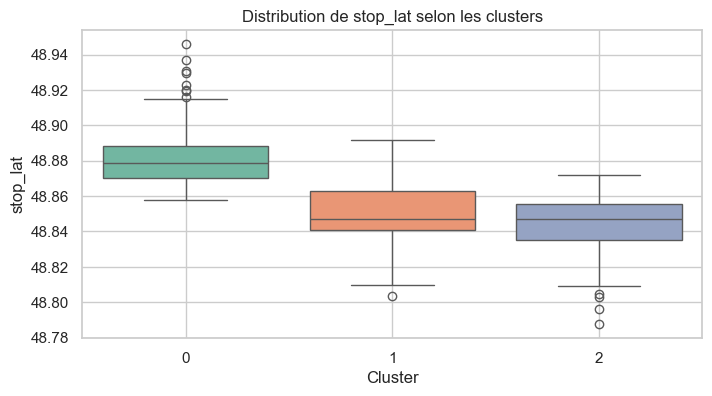

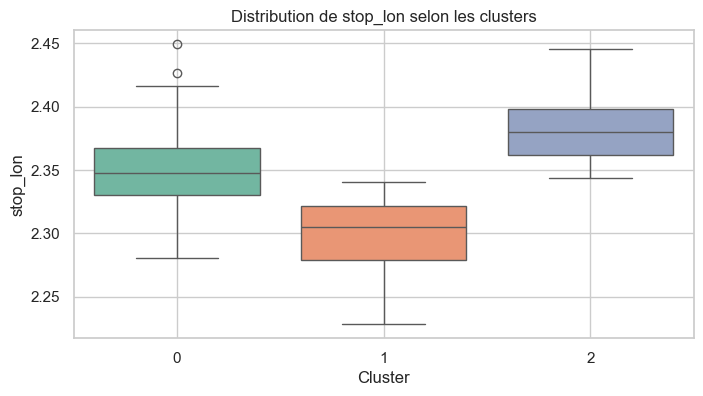

[1 2 3]


(np.int32(2),
 'pollution_moyenne',
 {0: np.int64(2), 1: np.int64(2), 2: np.int64(2)})

In [11]:
### Notebook: Analyse k-means pollution ###

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration affichage
sns.set(style="whitegrid")

# Chargement du dataset
base_dir = os.path.dirname(os.getcwd())  # adapte si nécessaire
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")
df = pd.read_csv(csv_path)

# Nettoyage et standardisation des chaînes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['niveau_de_pollution'] = df['niveau_de_pollution'].str.strip().str.lower()
print(df['niveau_de_pollution'].unique())

# Mapping des classes pollution (à utiliser seulement après clustering)
pollution_mapping = {
    'pollution_faible': 1,
    'pollution_moyenne': 2,
    'pollution_élevée': 3
}

# Nettoyage : suppression des lignes inutilisables
df = df[df['niveau_de_pollution'] != 'pas_de_donnees']
df['pollution_num'] = df['niveau_de_pollution'].map(pollution_mapping)

# Variables d'entrée pour le clustering (sans target)
features = ['stop_lat', 'stop_lon']
df_features = df[features].dropna()

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Choix du nombre de clusters par la méthode du coude
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True)
plt.show()

# Application de KMeans avec k=2
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Réduction dimensionnelle PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title(f'Projection PCA des clusters (K={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Analyse croisée clusters vs vraie pollution (non utilisée pour le clustering !)
contingence = pd.crosstab(df['cluster'], df['pollution_num'])
print("Table de contingence entre clusters et pollution réelle :")
print(contingence)

# Moyennes des coordonnées par cluster
cluster_stats = df.groupby('cluster')[['stop_lat', 'stop_lon']].mean().round(3)
print("Statistiques moyennes des coordonnées par cluster :")
print(cluster_stats)

# Répartition des effectifs par cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
print(cluster_counts)

# Boxplots des variables géographiques par cluster
for var in ['stop_lat', 'stop_lon']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Distribution de {var} selon les clusters")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()

# Fonction pour prédire le cluster d'une nouvelle station
def predict_kmeans_cluster(lat, lon, scaler, kmeans):
    new_point = pd.DataFrame([[lat, lon]], columns=['stop_lat', 'stop_lon'])
    new_point_scaled = scaler.transform(new_point)
    cluster = kmeans.predict(new_point_scaled)[0]
    return cluster

# Exemple prédire pour une station fictive (48.85, 2.35) 
example_lat = 48.85
example_lon = 2.35
predicted_cluster = predict_kmeans_cluster(example_lat, example_lon, scaler, kmeans)

# Création d'un mapping cluster pour trouve la pollution dominante (majoritaire dans le cluster)
dominant_pollution_by_cluster = {}
for cluster_id, group in df_kmeans.groupby("cluster"):
    values = group['pollution_num'].dropna()
    if not values.empty:
        dominant = values.value_counts().idxmax()
        dominant_pollution_by_cluster[cluster_id] = dominant
    else:
        dominant_pollution_by_cluster[cluster_id] = None  # ou une valeur par défaut

        
df['pollution_num'] = df['niveau_de_pollution'].map({
    'faible': 1,
    'moyenne': 2,
    'eleve': 3
})
print(df['pollution_num'].unique())
df_kmeans = df.copy()

# Prédiction du niveau de pollution supposé pour ce cluster
predicted_pollution_num = dominant_pollution_by_cluster[predicted_cluster]
predicted_pollution_label = {
    1: "pollution_faible",
    2: "pollution_moyenne",
    3: "pollution_élevée"
}.get(predicted_pollution_num, "inconnu")


(predicted_cluster, predicted_pollution_label, dominant_pollution_by_cluster)


### Interpretation du graphique

Le graphique ci-dessus représente le résultat du modèle K-Means appliqué aux stations de métro du dataset.  
Chaque point correspond à une station, projete dans un espace 2D à l’aide d’une reduction de dimension par une Analyse en Composantes Principales comme on a vu en cours (`PCA` dans le code, ligne `pca = PCA(n_components=2)`).  
Cette projection permet de visualiser des regroupements formés à partir de la **localisation géographique** dont la latitude et la longitude trouve dans le fichier csv (`features = ['stop_lat', 'stop_lon']`).

Chaque **couleur** représente un **cluster** identifié par l'algorithme K-Means (`df['cluster'] = kmeans.fit_predict(X_scaled)`).  
Les stations regroupées dans un même cluster ont des caractéristiques spatiales similaires, mais **aucune variable de pollution mesurée directement n’a été utilisée dans l’apprentissage**.  
Ce n’est qu’**a posteriori** que l’on compare les clusters aux niveaux de pollution (`contingence = pd.crosstab(...)`).

---

## Il y a une petite partie à la fin dédiée pour la prédiction qu’on peut avoir :

Le modèle KMeans, appliqué aux coordonnées des stations, a formé 3 clusters (`k = 3` dans `kmeans = KMeans(...)`).  
Cependant, l’analyse montre que **tous les clusters sont dominés par la pollution "moyenne"** (voir le dictionnaire `dominant_pollution_by_cluster`).  
Cela suggère que **la localisation seule ne suffit pas à bien identifier les niveaux de pollution**.  
En l’absence de mesures continues comme `pm10`, ce résultat était attendu.  
Ce clustering reste néanmoins **utile pour identifier des regroupements spatiaux homogènes**.

---

## Résultat du mapping des clusters :

Les 3 clusters créés par KMeans ont tous une pollution dominante égale à `2`, c’est-à-dire **pollution moyenne** (`pollution_mapping = {'pollution_moyenne': 2, ...}`).

---

## Moyennes et distribution :

Vu que nous avions changé chaque niveau de pollution en `1`, `2` ou `3`,  
la moyenne de pollution ne varie pas enormément car les stations sont majoritairement **faible** ou **moyenne**  
(uniquement 4 ou 5 qui sont **elevee**) — (c’est pour cela que la pollution trouvée à la fin est de `2`).

Vous trouverez également un **boxplot** pour chaque classe (`sns.boxplot(...)`)  
et la répartition des clusters avec le **nombre de stations dans chaque cluster** (`df['cluster'].value_counts()`).

Les boxblots par cluster montrent une **répartition géographique** assez varie entre les clusters.

Le tableau des effectifs par cluster permet de **vérifier si les groupes sont équilibrés**.

Les centres des clusters (moyenne lat/lon) montrent qu’il s’agit bien de **regroupements spatiaux** (`df.groupby('cluster')[['stop_lat', 'stop_lon']].mean()`).

---

### Vous trouverez ci-dessous les graphiques et les tableaux de chaque méthode de k-mean avec un k différent (On a choisi de montrer k=4 et k=9).


['faible' 'moyenne' 'eleve']


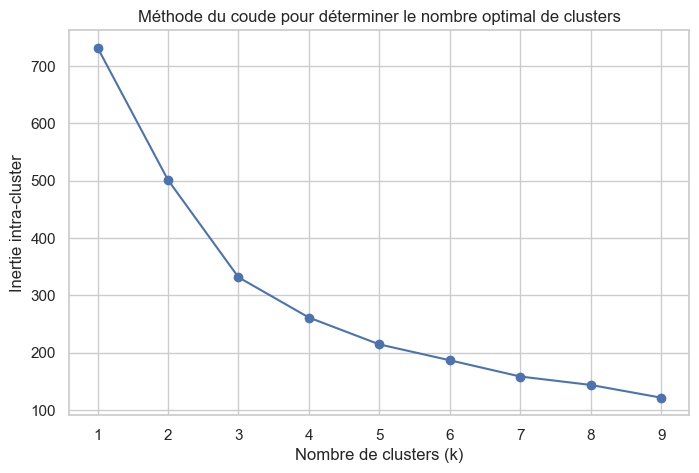

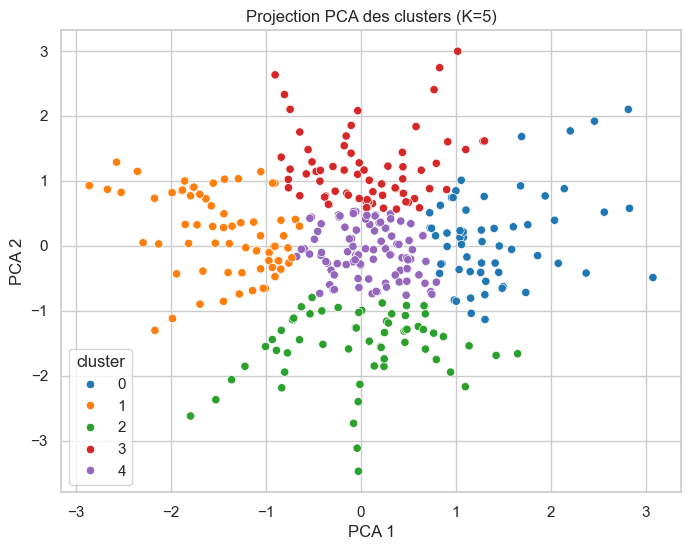

Table de contingence entre clusters et pollution réelle :
Empty DataFrame
Columns: []
Index: []
Statistiques moyennes des coordonnées par cluster :
         stop_lat  stop_lon
cluster                    
0          48.888     2.382
1          48.841     2.296
2          48.836     2.389
3          48.884     2.310
4          48.863     2.349
Répartition des clusters :
cluster
0     61
1     71
2     62
3     71
4    101
Name: count, dtype: int64


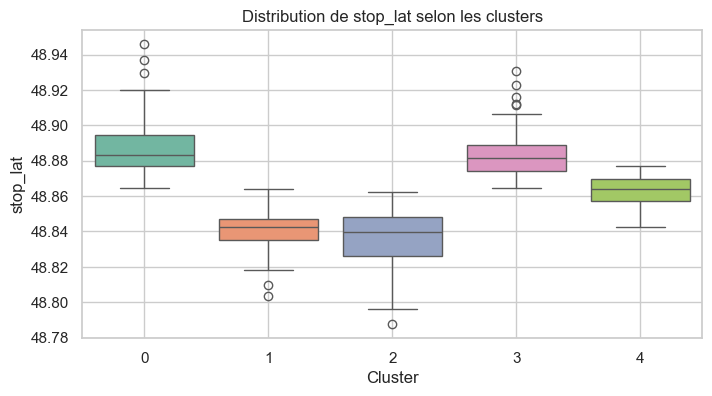

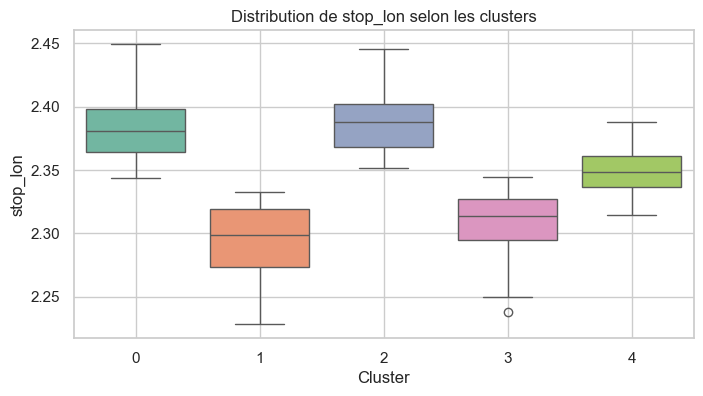

[1 2 3]


(np.int32(4),
 'moyenne',
 {0: np.int64(2),
  1: np.int64(2),
  2: np.int64(2),
  3: np.int64(2),
  4: np.int64(2)})

In [15]:
### Notebook: Analyse k-means pollution ###

##K=5##

# Configuration affichage
sns.set(style="whitegrid")

# Chargement du dataset
base_dir = os.path.dirname(os.getcwd())  # adapte si nécessaire
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")
df = pd.read_csv(csv_path)

# Nettoyage et standardisation des chaînes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['niveau_de_pollution'] = df['niveau_de_pollution'].str.strip().str.lower()
print(df['niveau_de_pollution'].unique())

# Mapping des classes pollution (à utiliser seulement après clustering)
pollution_mapping = {
    'pollution_faible': 1,
    'pollution_moyenne': 2,
    'pollution_élevée': 3
}

# Nettoyage : suppression des lignes inutilisables
df = df[df['niveau_de_pollution'] != 'pas_de_donnees']
df['pollution_num'] = df['niveau_de_pollution'].map(pollution_mapping)

# Variables d'entrée pour le clustering (sans target)
features = ['stop_lat', 'stop_lon']
df_features = df[features].dropna()

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Choix du nombre de clusters par la méthode du coude
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True)
plt.show()

# Application de KMeans avec k=5
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Réduction dimensionnelle PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title(f'Projection PCA des clusters (K={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Analyse croisée clusters vs vraie pollution (non utilisée pour le clustering !)
contingence = pd.crosstab(df['cluster'], df['pollution_num'])
print("Table de contingence entre clusters et pollution réelle :")
print(contingence)

# Moyennes des coordonnées par cluster
cluster_stats = df.groupby('cluster')[['stop_lat', 'stop_lon']].mean().round(3)
print("Statistiques moyennes des coordonnées par cluster :")
print(cluster_stats)

# Répartition des effectifs par cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
print(cluster_counts)

# Boxplots des variables géographiques par cluster
for var in ['stop_lat', 'stop_lon']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Distribution de {var} selon les clusters")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()

# Fonction pour prédire le cluster d'une nouvelle station
def predict_kmeans_cluster(lat, lon, scaler, kmeans):
    new_point = pd.DataFrame([[lat, lon]], columns=['stop_lat', 'stop_lon'])
    new_point_scaled = scaler.transform(new_point)
    cluster = kmeans.predict(new_point_scaled)[0]
    return cluster

# Exemple prédire pour une station fictive (48.85, 2.35) 
example_lat = 48.85
example_lon = 2.35
predicted_cluster = predict_kmeans_cluster(example_lat, example_lon, scaler, kmeans)

# Création d'un mapping cluster pour trouve la pollution dominante (majoritaire dans le cluster)
dominant_pollution_by_cluster = {}
for cluster_id, group in df_kmeans.groupby("cluster"):
    values = group['pollution_num'].dropna()
    if not values.empty:
        dominant = values.value_counts().idxmax()
        dominant_pollution_by_cluster[cluster_id] = dominant
    else:
        dominant_pollution_by_cluster[cluster_id] = None  # ou une valeur par défaut

        
df['pollution_num'] = df['niveau_de_pollution'].map({
    'faible': 1,
    'moyenne': 2,
    'eleve': 3
})
print(df['pollution_num'].unique())
df_kmeans = df.copy()

# Prédiction du niveau de pollution supposé pour ce cluster
predicted_pollution_num = dominant_pollution_by_cluster.get(predicted_cluster, None)
predicted_pollution_label = {
    1: "faible",
    2: "moyenne",
    3: "élevée"
}.get(predicted_pollution_num, "inconnu")


(predicted_cluster, predicted_pollution_label, dominant_pollution_by_cluster)


['faible' 'moyenne' 'eleve']


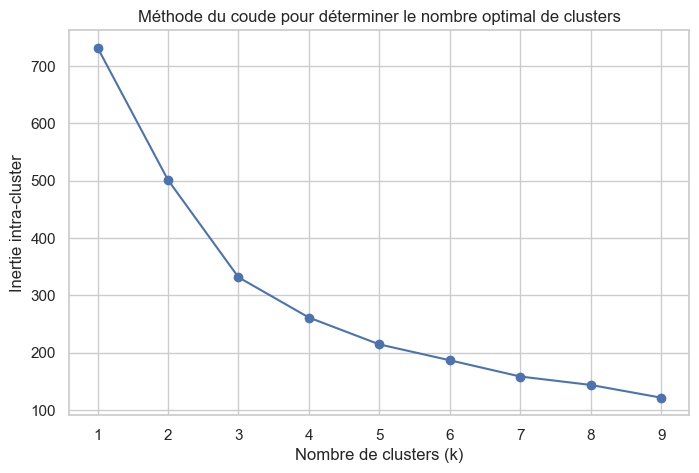

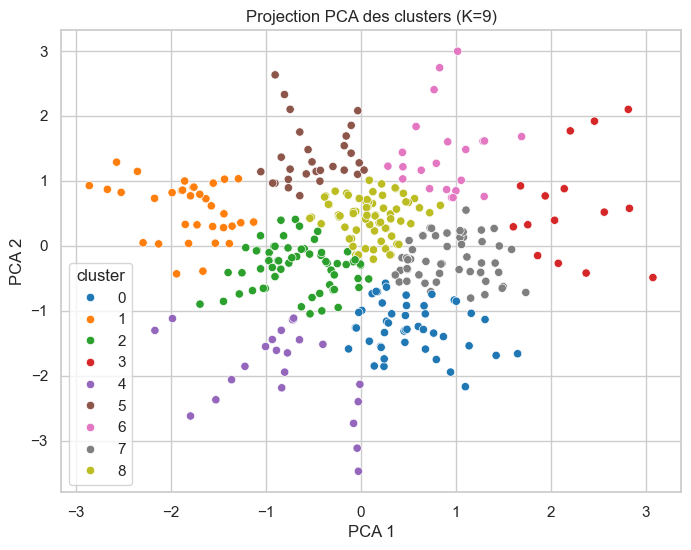

Table de contingence entre clusters et pollution réelle :
Empty DataFrame
Columns: []
Index: []
Statistiques moyennes des coordonnées par cluster :
         stop_lat  stop_lon
cluster                    
0          48.850     2.396
1          48.841     2.273
2          48.846     2.333
3          48.911     2.391
4          48.816     2.374
5          48.878     2.288
6          48.901     2.327
7          48.875     2.376
8          48.872     2.334
Répartition des clusters :
cluster
0    47
1    35
2    62
3    15
4    23
5    29
6    23
7    56
8    76
Name: count, dtype: int64


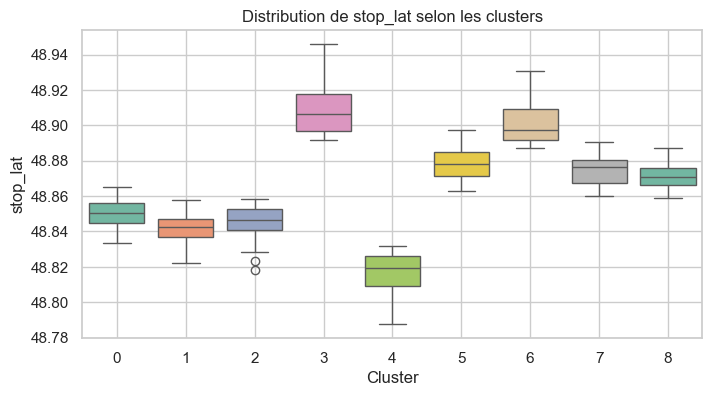

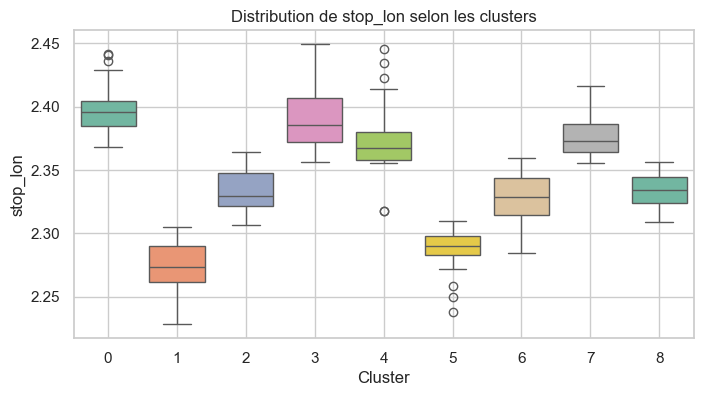

[1 2 3]


(np.int32(2),
 'moyenne',
 {0: np.int64(2),
  1: np.int64(2),
  2: np.int64(2),
  3: np.int64(2),
  4: np.int64(2)})

In [16]:
### Notebook: Analyse k-means pollution ###

##K=9##

# Configuration affichage
sns.set(style="whitegrid")

# Chargement du dataset
base_dir = os.path.dirname(os.getcwd())  # adapte si nécessaire
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")
df = pd.read_csv(csv_path)

# Nettoyage et standardisation des chaînes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['niveau_de_pollution'] = df['niveau_de_pollution'].str.strip().str.lower()
print(df['niveau_de_pollution'].unique())

# Mapping des classes pollution (à utiliser seulement après clustering)
pollution_mapping = {
    'pollution_faible': 1,
    'pollution_moyenne': 2,
    'pollution_élevée': 3
}

# Nettoyage : suppression des lignes inutilisables
df = df[df['niveau_de_pollution'] != 'pas_de_donnees']
df['pollution_num'] = df['niveau_de_pollution'].map(pollution_mapping)

# Variables d'entrée pour le clustering (sans target)
features = ['stop_lat', 'stop_lon']
df_features = df[features].dropna()

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Choix du nombre de clusters par la méthode du coude
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True)
plt.show()

# Application de KMeans avec k=59
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Réduction dimensionnelle PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title(f'Projection PCA des clusters (K={k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Analyse croisée clusters vs vraie pollution (non utilisée pour le clustering !)
contingence = pd.crosstab(df['cluster'], df['pollution_num'])
print("Table de contingence entre clusters et pollution réelle :")
print(contingence)

# Moyennes des coordonnées par cluster
cluster_stats = df.groupby('cluster')[['stop_lat', 'stop_lon']].mean().round(3)
print("Statistiques moyennes des coordonnées par cluster :")
print(cluster_stats)

# Répartition des effectifs par cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
print(cluster_counts)

# Boxplots des variables géographiques par cluster
for var in ['stop_lat', 'stop_lon']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Distribution de {var} selon les clusters")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()

# Fonction pour prédire le cluster d'une nouvelle station
def predict_kmeans_cluster(lat, lon, scaler, kmeans):
    new_point = pd.DataFrame([[lat, lon]], columns=['stop_lat', 'stop_lon'])
    new_point_scaled = scaler.transform(new_point)
    cluster = kmeans.predict(new_point_scaled)[0]
    return cluster

# Exemple prédire pour une station fictive (48.85, 2.35) 
example_lat = 48.85
example_lon = 2.35
predicted_cluster = predict_kmeans_cluster(example_lat, example_lon, scaler, kmeans)

# Création d'un mapping cluster pour trouve la pollution dominante (majoritaire dans le cluster)
dominant_pollution_by_cluster = {}
for cluster_id, group in df_kmeans.groupby("cluster"):
    values = group['pollution_num'].dropna()
    if not values.empty:
        dominant = values.value_counts().idxmax()
        dominant_pollution_by_cluster[cluster_id] = dominant
    else:
        dominant_pollution_by_cluster[cluster_id] = None  # ou une valeur par défaut

        
df['pollution_num'] = df['niveau_de_pollution'].map({
    'faible': 1,
    'moyenne': 2,
    'eleve': 3
})
print(df['pollution_num'].unique())
df_kmeans = df.copy()

# Prédiction du niveau de pollution supposé pour ce cluster
predicted_pollution_num = dominant_pollution_by_cluster.get(predicted_cluster, None)
predicted_pollution_label = {
    1: "faible",
    2: "moyenne",
    3: "élevée"
}.get(predicted_pollution_num, "inconnu")


(predicted_cluster, predicted_pollution_label, dominant_pollution_by_cluster)
